# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Homewor: Inference in NN 

**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors:** Pavlos Protopapas, Mark Glickman, Chris Tanner<br/>

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
#RUN THIS CELL
import os
import pathlib
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler

sns.set()

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, History 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import cross_val_score,  KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers

from functools import partial

np.random.seed(0)


%matplotlib notebook
%matplotlib inline

<div class="theme"> Overview </div> 

In this homework, we will investigate methods for uncertainty quantification in deep neural networks. These are alternatives to the robust MCMC that doesn't scale to large models.

<div class='exercise'><b> Question 1: Dropout as a Bayesian Approximation [10 pts] (Gal & Ghahramani 2015, https://arxiv.org/abs/1506.02142)</b></div>  

For this question, we will be generate a synthetic dataset in order to be able to test different uncertainty regimes, we will train the model with a gap in the data. 

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer. 

**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.

**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.

**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region two standard deviations away, as in **1.3**

**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.



## Answers

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.


In [204]:
def build_dataset(N, noise_std=0.25, is_test=True):
    # your code here
    if is_test:
        x = np.linspace(-4,4,N)
    else:
        x = np.concatenate([np.linspace(-4,-1,N/2),np.linspace(1,4,N/2)])
    y = 0.1*x**3 + noise_std*np.random.randn(N)
    return [x,y]
    

In [205]:
# your code here

x_train, y_train = build_dataset(200, is_test=False)
x_test, y_test = build_dataset(80, is_test=True)


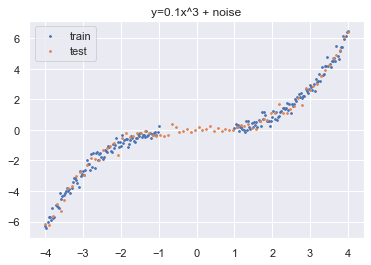

In [275]:
# your code here
plt.scatter(x_train, y_train, s=3, label='train')
plt.scatter(x_test, y_test, s=3, label='test')
plt.title("y=0.1x^3 + noise")
plt.legend()

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer.


In [134]:
# https://github.com/keras-team/keras/issues/9412

class Dropout(layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=None, noise_shape=None, seed=None, **kwargs):
        super(Dropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

In [202]:
# create model 
# your code here 

tf.keras.backend.clear_session()

input_layer = tf.keras.layers.Input((1,))
x = Dense(20, activation='relu')(input_layer)
x = Dense(20, activation='relu')(x)
x = Dense(20, activation='relu')(x)

drop = Dropout(0.1)(x, training=True) 
output = Dense(1)(drop)

model = tf.keras.Model(input_layer,output)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))

In [207]:
# Fit the model
# your code here
x_train, x_test, y_train, y_test = x_train.reshape(-1,1), x_test.reshape(-1,1), y_train.reshape(-1,1),y_test.reshape(-1,1)
history = model.fit(x_train,y_train, epochs=20, verbose=0)

In [208]:
# evaluate the training and testing performance of your model 
# your code here
print('\n# Evaluate on train data')
results_train = model.evaluate(x_train, y_train, verbose=0)
print('train mse loss:', results_train)

print('\n# Evaluate on test data')
results_test = model.evaluate(x_test, y_test, verbose=0)
print('test mse loss', results_test)


# Evaluate on train data
train mse loss: 0.27487519204616545

# Evaluate on test data
test mse loss 0.24322231709957123


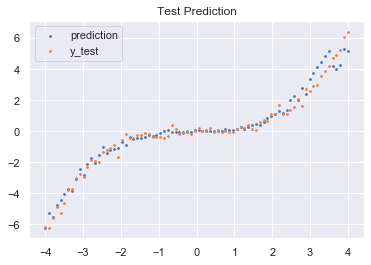

In [276]:
# plot 
# your code here 
pred = model.predict(x_test)
plt.scatter(x_test, pred, s=3, label='prediction')
plt.scatter(x_test, y_test, s=3, label='y_test')
plt.title('Test Prediction')
plt.legend()

**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.


In [263]:
# your code here
tf.keras.backend.clear_session()

input_layer = tf.keras.layers.Input((1,))
x = Dense(20, activation='relu')(input_layer)
x = Dense(20, activation='relu')(x)
x = Dense(20, activation='relu')(x)

drop = Dropout(0.1)(x, training=True) 
output = Dense(1)(drop)

model1 = tf.keras.Model(input_layer,output)

model1.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))
model1.fit(x_train,y_train, epochs=20, verbose=0)

results1=model1.predict(x_test) #first iterations
for i in range(1,10): #2nd-10th iterations
    results1 = np.concatenate((results1,model1.predict(x_test)),axis=1)

mean1 = np.mean(results1, axis=1)
std1 = np.std(results1, axis=1)



In [198]:
# your code here

tf.keras.backend.clear_session()

input_layer = tf.keras.layers.Input((1,))
x = Dense(20, activation='relu')(input_layer)
x = Dense(20, activation='relu')(x)
x = Dense(20, activation='relu')(x)

drop = Dropout(0.2)(x, training=True) 
output = Dense(1)(drop)

model2 = tf.keras.Model(input_layer,output)

model2.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))
model2.fit(x_train,y_train, epochs=20, verbose=0)

results2=model2.predict(x_test) #first iterations
for i in range(1,10): #2nd-10th iterations
    results2 = np.concatenate((results2,model2.predict(x_test)),axis=1)

mean2 = np.mean(results2, axis=1)
std2 = np.std(results2, axis=1)


**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.


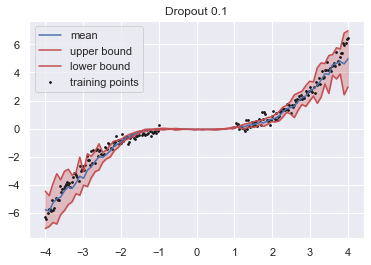

In [264]:
# plot 
# your code here
# lower1, upper1 = np.percentile(results1, [2.5, 97.5], axis=1) #for 95% CI
lower1, upper1 = mean1 - 2*std1, mean1 + 2*std1 #CI = 2 std deviation away from mean

plt.plot(x_test, mean1, c='b', label='mean')
plt.plot(x_test, lower1, c='r', label='upper bound')
plt.plot(x_test, upper1, c='r', label='lower bound')
plt.fill_between(x_test.reshape(1,-1)[0], lower1, upper1, alpha=0.3, color='r')
plt.scatter(x_train, y_train, s=3, c='k', label='training points')
plt.title('Dropout 0.1')
plt.legend()

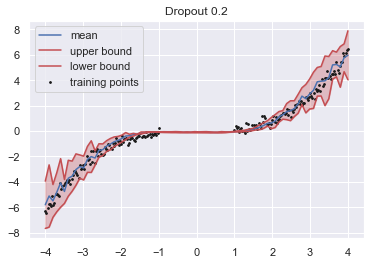

In [261]:
# lower2, upper2 = np.percentile(results2, [2.5, 97.5], axis=1) #for 95% CI
lower2, upper2 = mean2 - 2*std2, mean2 + 2*std2 #CI = 2 std deviation away from mean

plt.plot(x_test, mean2, c='b', label='mean')
plt.plot(x_test, lower2, c='r', label='upper bound')
plt.plot(x_test, upper2, c='r', label='lower bound')
plt.fill_between(x_test.reshape(1,-1)[0], lower2, upper2, alpha=0.3, color='r')
plt.scatter(x_train, y_train, s=3, c='k', label='training points')
plt.title('Dropout 0.2')
plt.legend()

**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region tow standard deviations away, as in **1.3**


In [250]:
# define model 
# your code here 
tf.keras.backend.clear_session()

input_layer = tf.keras.layers.Input((1,))
x = Dense(20, activation='relu')(input_layer)
x = Dense(20, activation='relu')(x)
x = Dense(20, activation='relu')(x)

drop = Dropout(0)(x, training=True) 
output = Dense(1)(drop)

model_bootstrap = tf.keras.Model(input_layer,output)

model_bootstrap.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))

In [216]:
# you may need this 
# from https://github.com/keras-team/keras/issues/341#issuecomment-438347068

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
    for k, initializer in layer.__dict__.items():
        if "initializer" not in k:
            continue
        # find the corresponding variable
        var = getattr(layer, k.replace("_initializer", ""))
        var.assign(initializer(var.shape, var.dtype))

In [270]:
# idx = np.random.randint(0,len(x_train)-1,10)
# x_train[idx]

In [271]:
# Bootstrap and run model 
# your code here 

# from sklearn.utils import resample

for i in range(50):
        
    # bootstrap training data
    idx = np.random.randint(0,len(x_train)-1,len(x_train))
    X_boot, y_boot = x_train[idx], y_train[idx]
#     train = resample(np.concatenate((x_train, y_train),axis=1))
#     X_boot, y_boot = np.hsplit(train,2)
    
    # fit to bootstrapped data
    model_bootstrap.fit(X_boot, y_boot, epochs=20, verbose=0)
    
    if i==0:
        results_bootstrap = model_bootstrap.predict(x_test) #first iterations
    else:
        results_bootstrap = np.concatenate((results_bootstrap,model_bootstrap.predict(x_test)),axis=1)
    
    reset_weights(model_bootstrap)

In [272]:
mean_bootstrap = np.mean(results_bootstrap, axis=1)
std_bootstrap = np.std(results_bootstrap, axis=1)

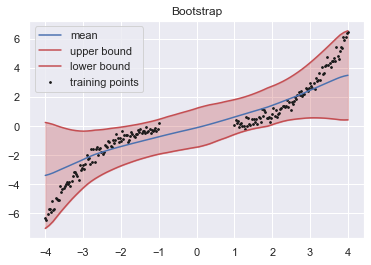

In [273]:
# plot 
# your code here 

# lower, upper = np.percentile(results_bootstrap, [2.5, 97.5], axis=1) #for 95% CI
lower, upper = mean_bootstrap - 2*std_bootstrap, mean_bootstrap + 2*std_bootstrap

plt.plot(x_test, mean_bootstrap, c='b', label='mean')
plt.plot(x_test, lower, c='r', label='upper bound')
plt.plot(x_test, upper, c='r', label='lower bound')
plt.fill_between(x_test.reshape(1,-1)[0], lower, upper, alpha=0.3, color='r')
plt.scatter(x_train, y_train, s=3, c='k', label='training points')
plt.title('Bootstrap')
plt.legend()

**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.


*Your answer here*

In the first method (using dropout layer), only *one* network is trained to minimize the loss on the training dataset. Then, at testing time, multiple models (*n=10*) are generated, applying a stochastic dropout mask to the initial network. This means all the models share the same weights. Basically, diversity in the models is the result of dropout masks.

For the method using dropout layer, we can see that increasing our dropout rate causes an increase in the stdev/variances (the plot shows wider confidence interval - specified by 2 sd). This makes sense, because the more neurons being dropped out of the network, the higher the variance in the output. This would lead to larger intervals that would capture our target value. One of the cons of this approach is that it requires making *n=10* number of predictions for every new datapoint. Depending on the use case this might not be feasible for real time inference.

In second method (with bootstrap), we make *n=50* different models; each model is trained separately to minimize the loss on a different (bootstrap) sample of the training data. This ensures diversity in the models. 

Comparing the plots in 1.3 and 1.5, it can be seen that the CI from bootstrap method are wider than the CI from the dropout method. But this bootstrap's CI does cover all the training points (compared to dropout method, some training points are not covered by the thin CI layer around the missing points in [-1,1]). However, the mean from the bootstrap method seems to resemble more like a straight line rather than a cubic function curve, while in the dropout method the mean curve is still resembling a cubic function. 

Downside of bootstrap method: since bootstrap method basically estimates the uncertainty/variance and confidence interval through the standard error, it won't work if the normality ssumptions are not met in the sampling distributions of the model’s residuals, and parameters. Moreover, bootstrapping techniques won’t work when we’re dealing with large and complex neural networks. 
